# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported.

In [42]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Just run the next cell to load the data.

In [43]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [44]:
diabetes['Overweight'] = (diabetes['BMI'] > 25).astype(int)
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,138,62,35,0,33.6,0.127,47,1,1
1,0,84,82,31,125,38.2,0.233,23,0,1
2,0,145,0,0,0,44.2,0.630,31,1,1
3,0,135,68,42,250,42.3,0.365,24,1,1
4,1,139,62,41,480,40.7,0.536,21,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0,1
1996,8,179,72,42,130,32.7,0.719,36,1,1
1997,6,85,78,0,0,31.2,0.382,42,0,1
1998,0,129,110,46,130,67.1,0.319,26,1,1


You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**. 

In [45]:
def discretize(df):

    """
    This function receives a dataframe as input and returns a dataframe in which each variable has been
    discretized.
    """

    discretized_df = df.copy()
    exclude = {'Overweight','Outcome'}

    for column in discretized_df:
        q1 = discretized_df[column].quantile(0.25)
        q2 = discretized_df[column].quantile(0.50)
        q3 = discretized_df[column].quantile(0.75)

        if column in exclude:
            continue

        for i, variable in enumerate(discretized_df[column]):  # enumerate to update values
            if variable < q1:
                discretized_df.at[i, column] = 0
            elif variable < q2:
                discretized_df.at[i, column] = 1
            elif variable < q3:
                discretized_df.at[i, column] = 2
            else:
                discretized_df.at[i, column] = 3

    return discretized_df

In [46]:
discrete_df = discretize(diabetes)

## Ilustración de variable

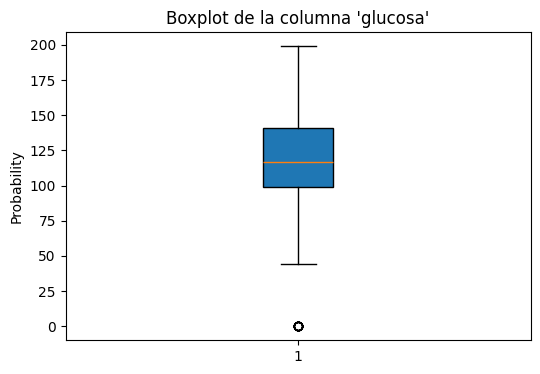

In [47]:
# Boxplot
plt.figure(figsize=(6,4))
plt.boxplot(diabetes["Glucose"], vert=True, patch_artist=True)
plt.title("Boxplot de la columna 'glucosa'")
plt.ylabel("Probability")
plt.show()

In [48]:
unique_values = discrete_df['Outcome'].unique()

In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [49]:
graph = {'Overweight': [], 
         'DiabetesPedigreeFunction': [], 
         'Age': [], 
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'], 
         'BMI': ['Overweight'],
         'Outcome': ['Overweight','DiabetesPedigreeFunction','Age','Pregnancies'],
         'BloodPressure': ['Outcome','Overweight'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}


values = {
    'Overweight': [0,1],
    'DiabetesPedigreeFunction': [0,1,2,3],
    'Age': [0,1,2,3],
    'Pregnancies': [0,1,2,3],
    'SkinThickness': [0,1,2,3],
    'BMI': [0,1,2,3],
    'Outcome': [0,1],
    'BloodPressure': [0,1,2,3],
    'Insulin': [0,1,2,3],
    'Glucose': [0,1,2,3]
}

values = {
    'Overweight': [0,1],
    'DiabetesPedigreeFunction': [0,1,2,3],
    'Age': [0,1,2,3],
    'Pregnancies': [0,1,2,3],
    'SkinThickness': [0,1,2,3],
    'BMI': [0,1,2,3],
    'Outcome': [0,1],
    'BloodPressure': [0,1,2,3],
    'Insulin': [0,1,2,3],
    'Glucose': [0,1,2,3]
}

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [50]:
import itertools

def probabilities(df, node):
    probabilities_list = []

    # padres del nodo
    parents = graph[node]

    # si no tiene padres -> prob marginal
    if not parents:
        total = len(df)
        for val in values[node]:
            count = len(df[df[node] == val])
            prob = count / total if total > 0 else 0
            probabilities_list.append({
                "node": node,
                "parents": {},
                "value": val,
                "probability": prob
            })
        return probabilities_list

    # si tiene padres -> prob condicional
    parent_values = [values[p] for p in parents]

    for combo in itertools.product(*parent_values):
        parent_condition = dict(zip(parents, combo))
        df_filtered = df.copy()
        for p, v in parent_condition.items():
            df_filtered = df_filtered[df_filtered[p] == v]

        total_parent = len(df_filtered)

        for val in values[node]:
            count = len(df_filtered[df_filtered[node] == val])
            prob = count / total_parent if total_parent > 0 else 0.5

            probabilities_list.append({
                "node": node,
                "parents": parent_condition,
                "value": val,
                "probability": prob
            })

    return probabilities_list


In [51]:
check= probabilities(discrete_df,'Outcome')
pd.DataFrame(check[0])

,node,parents,value,probability
Overweight,Outcome,0,0,1.0
DiabetesPedigreeFunction,Outcome,0,0,1.0
Age,Outcome,0,0,1.0
Pregnancies,Outcome,0,0,1.0


como existen valor es que no pueden ser prob obtenemos 102 de suma con lo siguiente observaremos que valores son los que dan cero

In [52]:
# Convertir lista de diccionarios a DataFrame
df = pd.DataFrame(check)

# como parents es dict, lo pasamos a string para poder agrupar
df["parents_str"] = df["parents"].apply(lambda x: str(sorted(x.items())))

# agrupamos por parents y sumamos
assert_probability = df.groupby("parents_str")["probability"].sum().reset_index()

print(assert_probability)


                                           parents_str  probability
0    [('Age', 0), ('DiabetesPedigreeFunction', 0), ...          1.0
1    [('Age', 0), ('DiabetesPedigreeFunction', 0), ...          1.0
2    [('Age', 0), ('DiabetesPedigreeFunction', 0), ...          1.0
3    [('Age', 0), ('DiabetesPedigreeFunction', 0), ...          1.0
4    [('Age', 0), ('DiabetesPedigreeFunction', 0), ...          1.0
..                                                 ...          ...
123  [('Age', 3), ('DiabetesPedigreeFunction', 3), ...          1.0
124  [('Age', 3), ('DiabetesPedigreeFunction', 3), ...          1.0
125  [('Age', 3), ('DiabetesPedigreeFunction', 3), ...          1.0
126  [('Age', 3), ('DiabetesPedigreeFunction', 3), ...          1.0
127  [('Age', 3), ('DiabetesPedigreeFunction', 3), ...          1.0

[128 rows x 2 columns]


The following function must create a dictionary in which item is a node and its corresponding list of probabilities

In [53]:
def tables(df):
    """
    Returns a dictionary where each key is a node name
    and the value is a list of numeric probabilities for that node.
    """
    probabilities_tables = {}
    
    for node in graph.keys():  
        # llamamos a probabilities y extraemos solo los números
        probs = probabilities(df, node)
        probabilities_tables[node] = [entry['probability'] for entry in probs]
    
    return probabilities_tables



In [54]:
#asignar de la tabla de probabilidades las probanilidades de cada nodo como variable ind
tables_prob = tables(discrete_df)
sumas = []
long = []

for node in tables_prob:
    sum_node = sum(tables_prob[node])  
    sumas.append((node, sum_node))

for node in tables_prob:
    sum_node = len(tables_prob[node])
    long.append((node, sum_node))

In [55]:
overweight_probabilities=tables_prob['Overweight']
diabetes_pedigree_function_probabilities=tables_prob['DiabetesPedigreeFunction']
age_probabilities=tables_prob['Age']
pregnancies_probabilities=tables_prob['Pregnancies']
skin_thickness_probabilities=tables_prob['SkinThickness']
bmi_probabilities=tables_prob['BMI']
outcome_probabilities=tables_prob['Outcome']
blood_pressure_probabilities=tables_prob['BloodPressure']
insulin_probabilities=tables_prob['Insulin']
glucose_probabilities=tables_prob['Glucose']

In [56]:
values = {
    'Overweight': ['0','1'],
    'DiabetesPedigreeFunction': ['0','1','2','3'],
    'Age': ['0','1','2','3'],
    'Pregnancies': ['0','1','2','3'],
    'SkinThickness': ['0','1','2','3'],
    'BMI': ['0','1','2','3'],
    'Outcome': ['0','1'],
    'BloodPressure': ['0','1','2','3'],
    'Insulin': ['0','1','2','3'],
    'Glucose': ['0','1','2','3']
}

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [57]:
#crear los nodos para la red bayesiana usando valores posibles, nombre, probabilidades dado Xpadres
overweight = BbnNode(Variable(0, 'Overweight', values['Overweight']), overweight_probabilities)
diabetes_pedigree_function = BbnNode(Variable(1, 'DiabetesPedigreeFunction', values['DiabetesPedigreeFunction']), diabetes_pedigree_function_probabilities)
age = BbnNode(Variable(2, 'Age', values['Age']), age_probabilities)
pregnancies = BbnNode(Variable(3, 'Pregnancies', values['Pregnancies']), pregnancies_probabilities)
skin_thickness = BbnNode(Variable(4, 'SkinThickness', values['SkinThickness']), skin_thickness_probabilities)
bmi = BbnNode(Variable(5, 'BMI', values['BMI']), bmi_probabilities)
outcome = BbnNode(Variable(6, 'Outcome', values['Outcome']), outcome_probabilities)
blood_pressure = BbnNode(Variable(7, 'BloodPressure', values['BloodPressure']), blood_pressure_probabilities)
insulin = BbnNode(Variable(8, 'Insulin', values['Insulin']), insulin_probabilities)
glucose = BbnNode(Variable(9, 'Glucose', values['Glucose']), glucose_probabilities)

Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [58]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(outcome) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(pregnancies,outcome , EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight,outcome , EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome,insulin , EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome,glucose , EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome,blood_pressure , EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight,blood_pressure , EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight,skin_thickness , EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight,bmi , EdgeType.DIRECTED)) 
   # .add_edge(Edge(origin, destino, EdgeType.DIRECTED)) \

Do not forget to run this cell and do not modify it, inferences depend on it.

In [59]:
# Convert the BBN to a join tree. Do not modify this cell.
join_tree = InferenceController.apply(bbn)

In [60]:
potential = join_tree.get_bbn_potential(bmi)
print("Node:", age)
print("Values:")
print(potential)
print('----------------')

Node: 2|Age|0,1,2,3
Values:
5=0|0.25000
5=1|0.24900
5=2|0.25000
5=3|0.25100
----------------


The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

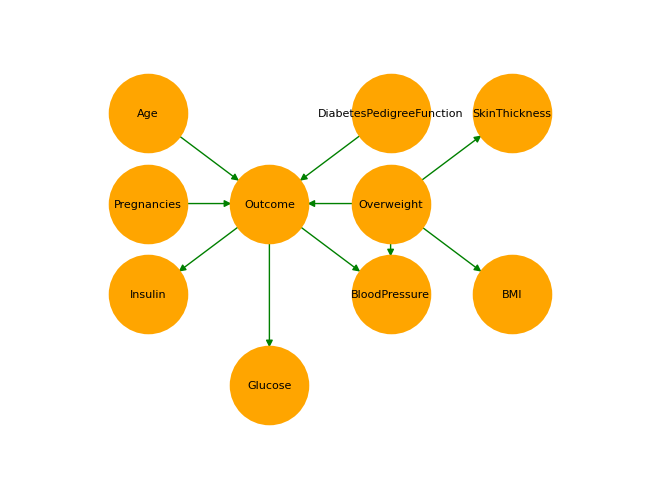

In [61]:


pos = {0:(10,0),1:(10,10),2:(-10,10),3:(-10,0),4:(20,10),5:(20,-10),6:(0,0),7:(10,-10),8:(-10,-10),9:(0,-20)}

options = {"font_size" : 8, "node_size" : 3000, "node_color" : "ORANGE", 
           "edgecolors" : "ORANGE", "edge_color" : "GREEN", "linewidths" : 2.5, 
           "width": 1}
    
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)
ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [62]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.15300
0=1|0.84700
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.48100
4=2|0.22900
4=3|0.29000
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.25000
5=1|0.24900
5=2|0.25000
5=3|0.25100
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.67886
6=1|0.32114
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.49884
8=2|0.24957
8=3|0.25159
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.24097
9=1|0.25846
9=2|0.25432
9=3|0.24625
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.25229
7=1|0.22574
7=2|0.26586
7=3|0.25612
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.23050
2=1|0.25950
2=2|0.24700
2=3|0.26300
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.15050
3=1|0.32000
3=2|0.26350
3=3|0.26600
----------------


The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [63]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network. 

In [64]:
# Use above function to add evidence.

evidence('ev1', 'BMI', '1', 1)
evidence('ev2', 'Overweight', '1', 1)
evidence('ev2', 'Age', '3', 1)

# Print marginal probabilities.

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.40791
4=2|0.25620
4=3|0.33589
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.00000
5=1|1.00000
5=2|0.00000
5=3|0.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.59839
6=1|0.40161
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.50140
8=2|0.23386
8=3|0.26474
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.21986
9=1|0.24706
9=2|0.25693
9=3|0.27615
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.21466
7=1|0.23785
7=2|0.26082
7=3|0.28667
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.00000
2=1|0.00000
2=2|0.00000
2=3|1.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.15050
3=1|0.32000
3=2|0.26350
3=3|0.26600
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [67]:
join_tree = InferenceController.apply(bbn)